In [1]:
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM, GRU
from keras.layers import Dense

import matplotlib as plt
get_ipython().magic(u'matplotlib inline')

import datetime as dt
import itertools
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf

C:\Users\samue\AppData\Local\Temp\ipykernel_6316\706976942.py:7: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic(u'matplotlib inline')


In [2]:
def split_sequence(sequence, n_steps=7, lookahead=0):
    X, y = list(), list()
    for i in range(lookahead,len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix >= len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i-lookahead:end_ix-lookahead], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

### Data preprocessing

In [3]:
tsdataframe = pd.read_csv('timeseries_lab3.csv')
tsdataframe

,Date,Price
0,1/1/2006,569.865168
1,1/2/2006,593.271930
2,1/3/2006,606.471193
3,1/4/2006,576.932773
4,1/5/2006,573.812500
...,...,...
3647,12/27/2015,832.554167
3648,12/28/2015,880.513919
3649,12/29/2015,856.883910
3650,12/30/2015,888.002212


In [4]:
tsdata = np.load('timeseries_lab3.npy')

In [5]:
tsdata

array([569.86516854, 593.27192983, 606.47119342, ..., 856.88391039,
       888.00221239, 918.49879518])

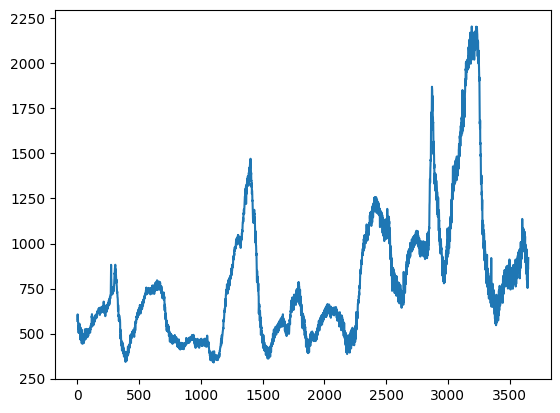

In [6]:
plt.plot(tsdata)

In [7]:
n_steps=7
n_features = 1
train_size = 2557

In [8]:
X, y = split_sequence(tsdata,n_steps)

In [9]:
X

array([[569.86516854, 593.27192983, 606.47119342, ..., 573.8125    ,
        576.17699115, 548.16748768],
       [593.27192983, 606.47119342, 576.93277311, ..., 576.17699115,
        548.16748768, 528.13043478],
       [606.47119342, 576.93277311, 573.8125    , ..., 548.16748768,
        528.13043478, 543.19517544],
       ...,
       [876.92110454, 923.34583333, 807.89142857, ..., 865.42385787,
        832.55416667, 880.51391863],
       [923.34583333, 807.89142857, 753.03703704, ..., 832.55416667,
        880.51391863, 856.88391039],
       [807.89142857, 753.03703704, 865.42385787, ..., 880.51391863,
        856.88391039, 888.00221239]])

In [10]:
X = X.reshape((X.shape[0], X.shape[1], n_features))
trainX = X[:train_size]
trainy = y[:train_size]
testX = X[train_size:]
testy = y[train_size:]

In [11]:
trainX[0]

array([[569.86516854],
       [593.27192983],
       [606.47119342],
       [576.93277311],
       [573.8125    ],
       [576.17699115],
       [548.16748768]])

### LSTM model for time series prediction

In [12]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [13]:
model.fit(trainX, trainy, epochs=20, verbose=1)

Epoch 1/20
80/80 [==============================] - 3s 18ms/step - loss: 253876.2188
Epoch 2/20
80/80 [==============================] - 2s 20ms/step - loss: 1378.4519
Epoch 3/20
80/80 [==============================] - 1s 18ms/step - loss: 832.3309
Epoch 4/20
80/80 [==============================] - 2s 20ms/step - loss: 848.8366
Epoch 5/20
80/80 [==============================] - 1s 17ms/step - loss: 863.3759
Epoch 6/20
80/80 [==============================] - 1s 18ms/step - loss: 801.8663
Epoch 7/20
80/80 [==============================] - 1s 17ms/step - loss: 772.5657
Epoch 8/20
80/80 [==============================] - 1s 18ms/step - loss: 781.6154
Epoch 9/20
80/80 [==============================] - 1s 19ms/step - loss: 745.7812
Epoch 10/20
80/80 [==============================] - 1s 18ms/step - loss: 735.0549
Epoch 11/20
80/80 [==============================] - 1s 18ms/step - loss: 734.9288
Epoch 12/20
80/80 [==============================] - 1s 19ms/step - loss: 737.2426
Epoch 13/

### Prediction (test set)

In [14]:
yhat = model.predict(testX, verbose=0)

In [15]:
pred = []
for i in range(yhat.shape[0]):
    pred.append(yhat[i])
pred = np.array(pred)

Text(0.5, 0, 'Days')

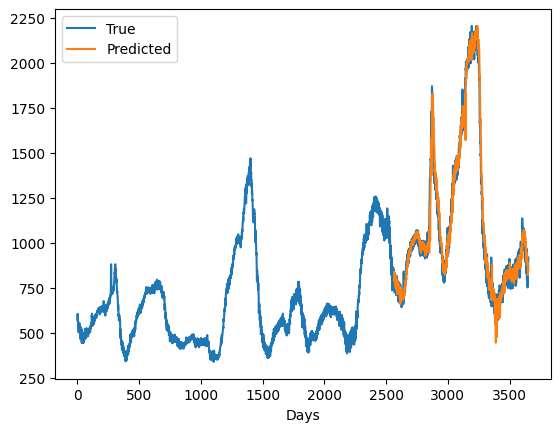

In [16]:
plt.plot(range(len(tsdata)),tsdata,label='True')
plt.plot(range(len(tsdata)-len(testy),len(tsdata)),pred,label='Predicted')
plt.legend(loc='upper left')
plt.xlabel('Days')



## Lab 4: Language Model

<b>Problem statement:</b> Use the following dataset containing element names to train a language model. Generate new names using the trained model. The generated names should resemble element names, e.g. ends with '-ium'

### Data

In [17]:
data = open('elements.txt', 'r').read()
data = data.lower()
vocab = sorted(set(data))
data_size, vocab_size = len(data), len(vocab)
chars = tf.strings.unicode_split(data.split('\n'), 'UTF-8')
data = data.replace('\n', '\n ').split(' ')
data[:5]

['hydrogen\n', 'helium\n', 'lithium\n', 'beryllium\n', 'boron\n']

In [18]:
max_len = len(max(data, key=len))
x, y = [], []

for word in data:
    tmp = (max_len - len(word)) * '0' + word
    x.append(tmp)
    y.append('')
    for i, j in enumerate(word):
        if (i >= len(word) - 1):
            break
        tmp = (max_len - len(word[:-1-i])) * '0' + word[:-1-i]
        x.append(tmp)
        y.append(word[-1-i])

In [24]:
y

['',
 '\n',
 'n',
 'e',
 'g',
 'o',
 'r',
 'd',
 'y',
 '',
 '\n',
 'm',
 'u',
 'i',
 'l',
 'e',
 '',
 '\n',
 'm',
 'u',
 'i',
 'h',
 't',
 'i',
 '',
 '\n',
 'm',
 'u',
 'i',
 'l',
 'l',
 'y',
 'r',
 'e',
 '',
 '\n',
 'n',
 'o',
 'r',
 'o',
 '',
 '\n',
 'n',
 'o',
 'b',
 'r',
 'a',
 '',
 '\n',
 'n',
 'e',
 'g',
 'o',
 'r',
 't',
 'i',
 '',
 '\n',
 'n',
 'e',
 'g',
 'y',
 'x',
 '',
 '\n',
 'e',
 'n',
 'i',
 'r',
 'o',
 'u',
 'l',
 '',
 '\n',
 'n',
 'o',
 'e',
 '',
 '\n',
 'm',
 'u',
 'i',
 'd',
 'o',
 '',
 '\n',
 'm',
 'u',
 'i',
 's',
 'e',
 'n',
 'g',
 'a',
 '',
 '\n',
 'm',
 'u',
 'i',
 'n',
 'i',
 'm',
 'u',
 'l',
 '',
 '\n',
 'n',
 'o',
 'c',
 'i',
 'l',
 'i',
 '',
 '\n',
 's',
 'u',
 'r',
 'o',
 'h',
 'p',
 's',
 'o',
 'h',
 '',
 '\n',
 'r',
 'u',
 'f',
 'l',
 'u',
 '',
 '\n',
 'e',
 'n',
 'i',
 'r',
 'o',
 'l',
 'h',
 '',
 '\n',
 'n',
 'o',
 'g',
 'r',
 '',
 '\n',
 'm',
 'u',
 'i',
 's',
 's',
 'a',
 't',
 'o',
 '',
 '\n',
 'm',
 'u',
 'i',
 'c',
 'l',
 'a',
 '',
 '\n',
 'm',
 'u'

In [19]:
ids_from_chars = keras.layers.StringLookup(vocabulary=list(vocab), mask_token=None)
chars_from_ids = tf.keras.layers.StringLookup(vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)
train_x = np.zeros((len(x), max_len, len(vocab)), dtype=bool)
train_y = np.zeros((len(x), len(vocab)), dtype=bool)
for i, seq in enumerate(x):
    for j, c in enumerate(seq):
        if c != '0':
            train_x[i, j, ids_from_chars(c).numpy()-1] = 1
    train_y[i, ids_from_chars(y[i]).numpy()-1] = 1

### Model Architecture

<img src="./rnn_langmod.png" style="width:500;height:300px;">

In [20]:
model = Sequential()
model.add(LSTM(64, input_shape=(max_len, vocab_size)))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy')

In [21]:
model.fit(train_x, train_y, epochs=20, verbose=1)

Epoch 1/20
33/33 [==============================] - 3s 7ms/step - loss: 3.1033
Epoch 2/20
33/33 [==============================] - 0s 6ms/step - loss: 2.7222
Epoch 3/20
33/33 [==============================] - 0s 5ms/step - loss: 2.5133
Epoch 4/20
33/33 [==============================] - 0s 5ms/step - loss: 2.3624
Epoch 5/20
33/33 [==============================] - 0s 5ms/step - loss: 2.2465
Epoch 6/20
33/33 [==============================] - 0s 5ms/step - loss: 2.1453
Epoch 7/20
33/33 [==============================] - 0s 5ms/step - loss: 2.0657
Epoch 8/20
33/33 [==============================] - 0s 5ms/step - loss: 2.0003
Epoch 9/20
33/33 [==============================] - 0s 5ms/step - loss: 1.9333
Epoch 10/20
33/33 [==============================] - 0s 5ms/step - loss: 1.8714
Epoch 11/20
33/33 [==============================] - 0s 5ms/step - loss: 1.8404
Epoch 12/20
33/33 [==============================] - 0s 5ms/step - loss: 1.7904
Epoch 13/20
33/33 [==============================

In [22]:
base = ["co", "rul", "mar", "ta", "pur", "bum", "daz", "latiss", "k", "q", "m", ""]
results = []
for i in base:
    seq = ('{0:0>' + str(max_len)+'}').format(i).lower()
    new_word = i
    
    while (len(new_word) < max_len):
        # Vectorize the input of the model.
        x_pred = np.zeros((1, max_len, vocab_size))
        for j, c in enumerate(seq):
            if c != '0' and j < x_pred.shape[1]:
                x_pred[0, j, ids_from_chars(c)-1] = 1

        # Predict the probabilities of the next char.
        preds = model.predict(x_pred, verbose=0)[0]
        preds = np.exp(preds) / np.sum(np.exp(preds))

        # Randomly sample from the top ten percent of probabilities 
        top_ten_pct = []
        for _ in range(np.ceil(len(preds)*.1).astype(np.int16)):
            index = np.where(preds == max(preds))[0][0]
            top_ten_pct.append(index)
            preds[index] = 0.0
        next_char = chars_from_ids(np.random.choice(top_ten_pct)+1) \
            .numpy().decode('utf-8')
        print(top_ten_pct)

        if next_char == '\n' or len(new_word) > max_len:
            break
        else:
            # Append the character
            new_word += next_char
            # Add pre-padding of zeros to the sequence generated and continue.
            seq = ('{0:0>' + str(max_len) + '}').format(new_word).lower()
    results.append(new_word)

for i in range(len(base)):
    print(f"Input Letters: {base[i]}\t |\t New Element: {results[i]}")

[16, 11, 13]
[9, 5, 1]
[19, 13, 5]
[12, 0, 13]
[0, 9, 5]
[0, 24, 13]
[0, 24, 9]
[19, 24, 0]
[9, 5, 14]
[13, 16, 0]
[14, 1, 5]
[13, 16, 11]
[9, 5, 0]
[13, 0, 9]
[19, 13, 0]
[11, 16, 13]
[9, 5, 1]
[13, 16, 11]
[9, 5, 0]
[14, 1, 5]
[13, 16, 18]
[9, 13, 0]
[9, 0, 5]
[19, 13, 0]
[12, 0, 19]
[0, 24, 9]
[24, 0, 13]
[24, 0, 9]
[19, 24, 0]
[12, 24, 0]
[9, 5, 14]
[13, 16, 11]
[9, 0, 5]
[19, 13, 0]
[9, 5, 16]
[16, 13, 11]
[9, 13, 14]
[9, 5, 0]
[9, 0, 5]
[13, 0, 16]
[0, 24, 9]
[19, 24, 0]
[12, 0, 19]
[0, 24, 9]
[24, 19, 0]
[12, 24, 0]
[1, 16, 5]
[14, 1, 5]
[13, 11, 16]
[9, 5, 13]
[13, 0, 9]
[1, 5, 14]
[16, 11, 13]
[9, 5, 1]
[13, 16, 17]
[9, 0, 5]
[0, 13, 17]
[0, 9, 5]
[1, 5, 14]
[16, 11, 1]
[5, 1, 9]
[16, 13, 11]
[9, 5, 13]
[13, 9, 16]
[9, 0, 5]
[0, 13, 19]
[0, 9, 24]
[1, 16, 5]
[16, 11, 1]
[14, 5, 1]
[13, 16, 11]
[9, 5, 13]
[13, 9, 16]
[9, 0, 5]
Input Letters: co	 |	 New Element: conieneni
Input Letters: rul	 |	 New Element: rule
Input Letters: mar	 |	 New Element: marenei
Input Letters: ta	 |	 N

### References:

https://www.tensorflow.org/text/tutorials/text_generation#build_the_model

https://medium.com/analytics-vidhya/business-name-generator-with-tensorflow-eba86c35d9cf